# 图像增广

## 数据增强
- 增加一个已有数据集，使得有更多的多样性
  - 在语言里面加入各种不同的背景噪音
  - 改变图片的颜色和形状

## 使用数据增强训练
原始数据(在线生成->)增强后数据(训练->)

## 翻转
- 左右翻转
- 上下翻转
  - 不总是可行

## 切割
- 从图片中切割一块，然后变形到固定形状
  - 随机高宽比: 3/4，4/3
  - 随机大小: 8%，100% 
  - 随机位置
## 颜色
- 改变：色调、饱和度、明亮度

## 其他
[imgaug](https://github.com/aleju/imgaug) 中提供了几十种不同的图像增强的方法

- 高斯模糊
- 将图片中的某一块抹掉
- 对整个图片进行变形
- 锐化
- 等等


某一种数据增强的方法有用，很多时候是因为测试集中某些图片和原始图片通过这种数据增强的方式处理之后的效果类似

很多时候应该从结果向前推，通过对现场部署的情况或者测试集可能发生的变化进行分析，由此来反推所需要进行的数据增强
在实践中，通常结合多种图像增广方法

## 总结
- 数据增强通过变形数据来获取多样性从而使得模型泛化性能更好（基于现有的训练数据生成随机图像，以提高模型的泛化能力，本质上是希望通过对原始数据的变化来模拟现场部署或者是测试集中可能出现的情况）
- 常见的图片增强包括翻转、切割、变色
- 为了在预测过程中得到确切的结果，通常会只对训练样本进行图像增广，而在预测过程中不使用带随机操作的图像增广
- 在实践中，通常会组合使用多种图像增广方法


# 代码实现

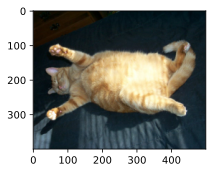

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
import d2l_source.d2l as d2l

d2l.set_figsize()
img = d2l.Image.open('../data/img/cat1.jpg')
d2l.plt.imshow(img)

In [2]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    """在img上运行aug方法并显示所有结果"""
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

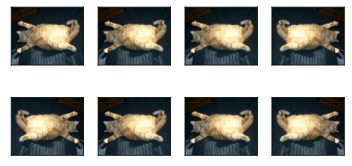

In [3]:
# 概率左右翻转
apply(img, torchvision.transforms.RandomHorizontalFlip())

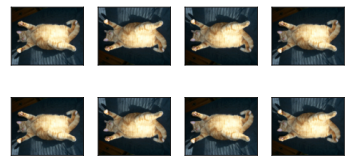

In [4]:
# 概率上下翻转
apply(img, torchvision.transforms.RandomVerticalFlip())

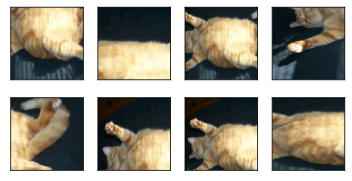

In [5]:
# 剪裁并缩放至原来大小
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

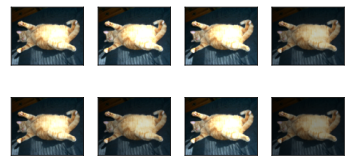

In [6]:
# 颜色改变：亮度、对比度、饱和度和色调
# 亮度
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

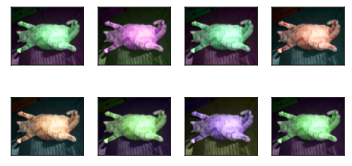

In [7]:
# 色调
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

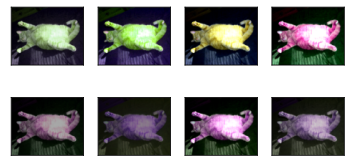

In [8]:
# 混合颜色改变
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

## 使用图像增广进行训练

Files already downloaded and verified


array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
       <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >],
      dtype=object)

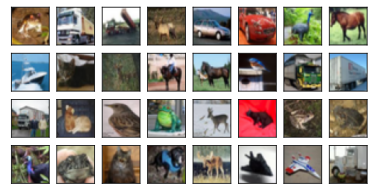

In [9]:
all_images = torchvision.datasets.CIFAR10(train=True, root="../data",
                                          download=True)
d2l.show_images([all_images[i][0] for i in range(32)], 4, 8, scale=0.8)

对数据进行图像增广

只对训练数据增广

In [10]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

读取图像和引用图像增广

In [11]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(root="../data", train=is_train,
                                           transform=augs, download=True)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                    shuffle=is_train, num_workers=d2l.get_dataloader_workers())
    return dataloader

多GPU训练

...GG


In [12]:
#@save
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [13]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

使用图影增广来训练模型

In [14]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

训练

In [ ]:
train_with_data_aug(train_augs, test_augs, net)